# Лабораторная работа 6: Логистическая регрессия

## Реализация без использования библиотек машинного обучения, только NumPy и Pandas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Настройка отображения графиков
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

## 1. Загрузка и предварительная обработка данных

In [2]:
# Загрузка данных
df = pd.read_csv("data/Titanic.csv")

print("1. ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ")
print("=" * 50)

# Проверка на отсутствующие значения
print("Проверка отсутствующих значений:")
print(df.isnull().sum())
print()

# Информация о датасете
print("Информация о датасете:")
print(df.info())
print()

# Выделение признаков и целевой переменной
X = df.drop("Survived", axis=1)
y = df["Survived"]

print(f"Размерность признаков: {X.shape}")
print(f"Размерность целевой переменной: {y.shape}")
print()

1. ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ
Проверка отсутствующих значений:
PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 

## 2. Статистика и визуализация данных

In [3]:
print("2. СТАТИСТИКА И ВИЗУАЛИЗАЦИЯ ДАННЫХ")
print("=" * 50)

# Базовая статистика
print("Статистика датасета:")
print(df.describe())
print()

2. СТАТИСТИКА И ВИЗУАЛИЗАЦИЯ ДАННЫХ
Статистика датасета:
       PassengerId     Survived       Pclass          Age        SibSp  \
count  1309.000000  1309.000000  1309.000000  1046.000000  1309.000000   
mean    655.000000     0.377387     2.294882    29.881138     0.498854   
std     378.020061     0.484918     0.837836    14.413493     1.041658   
min       1.000000     0.000000     1.000000     0.170000     0.000000   
25%     328.000000     0.000000     2.000000    21.000000     0.000000   
50%     655.000000     0.000000     3.000000    28.000000     0.000000   
75%     982.000000     1.000000     3.000000    39.000000     1.000000   
max    1309.000000     1.000000     3.000000    80.000000     8.000000   

             Parch         Fare  
count  1309.000000  1308.000000  
mean      0.385027    33.295479  
std       0.865560    51.758668  
min       0.000000     0.000000  
25%       0.000000     7.895800  
50%       0.000000    14.454200  
75%       0.000000    31.275000  
max 

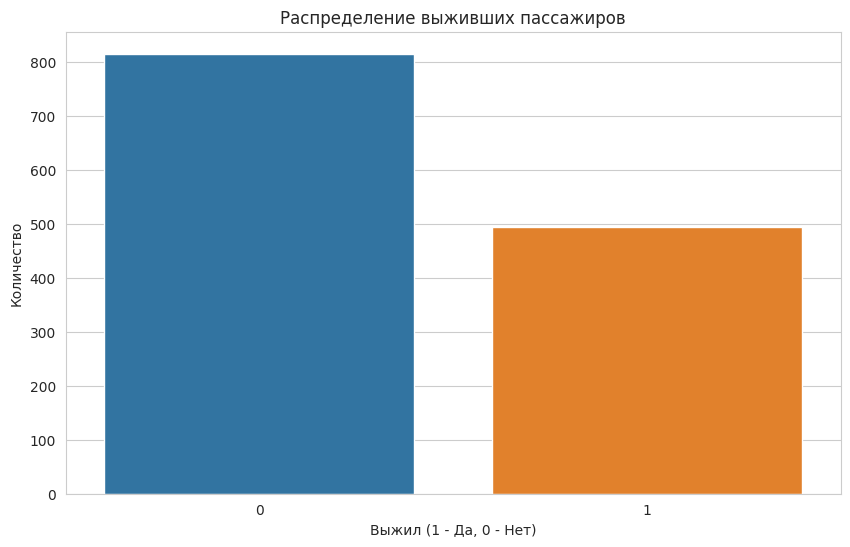

In [4]:
# Визуализация распределения классов
plt.figure(figsize=(10, 6))
sns.countplot(x="Survived", data=df)
plt.title("Распределение выживших пассажиров")
plt.xlabel("Выжил (1 - Да, 0 - Нет)")
plt.ylabel("Количество")
plt.show()

### 2.1. Визуализация распределения признаков

2.1. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ПРИЗНАКОВ


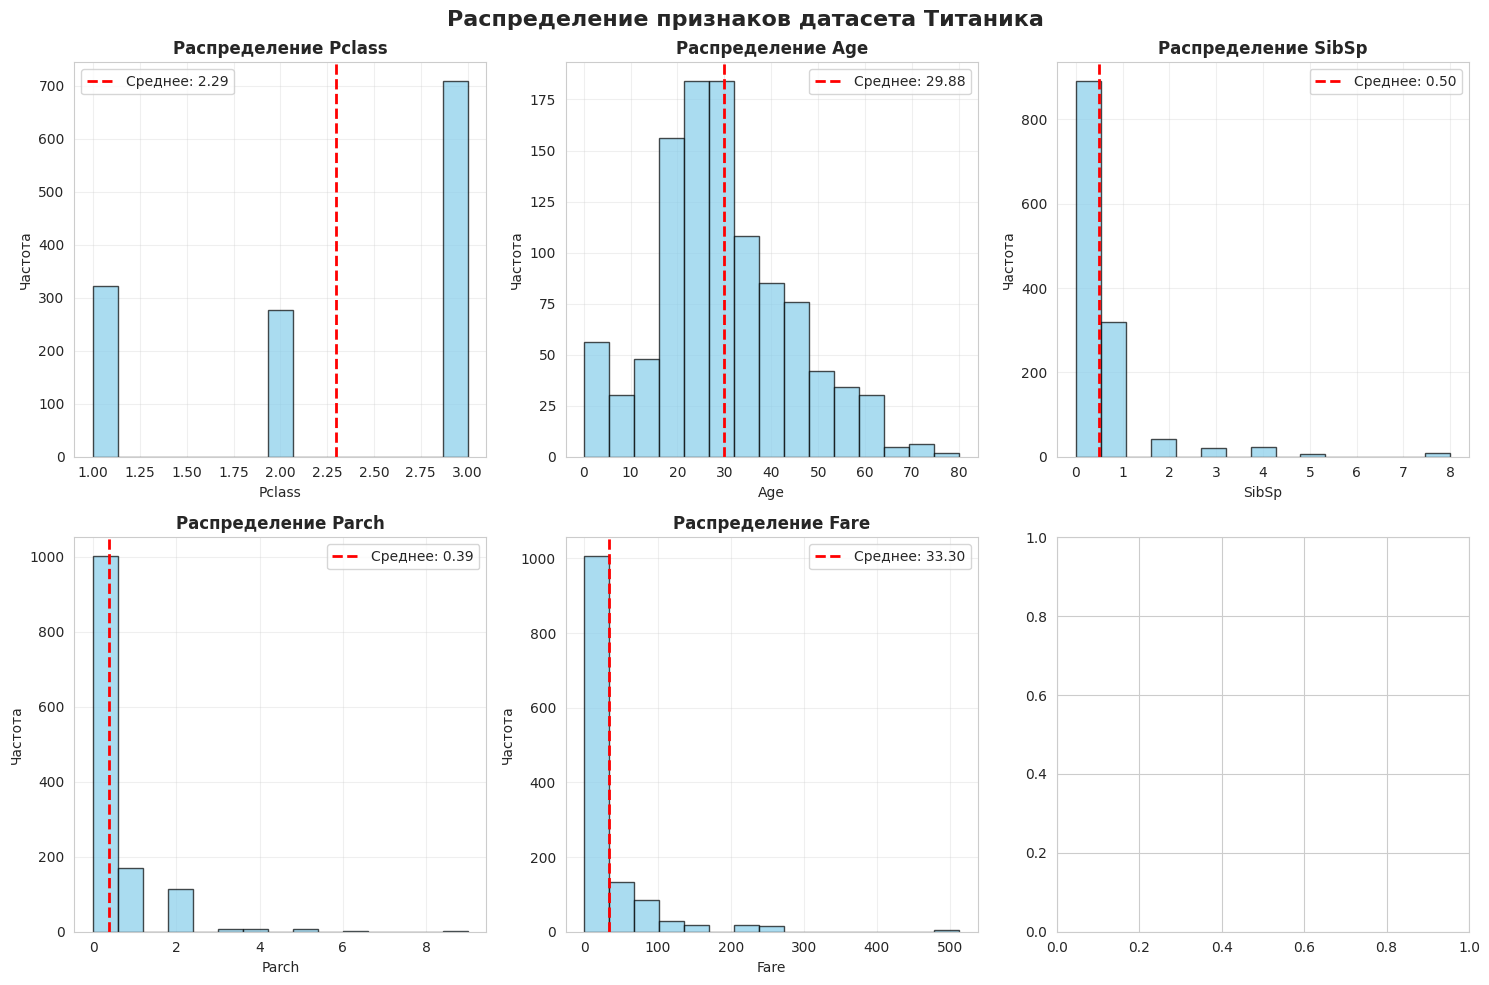

In [5]:
print("2.1. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ПРИЗНАКОВ")
print("=" * 50)

# Создание сетки графиков
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Распределение признаков датасета Титаника", fontsize=16, fontweight="bold")

# Построение гистограмм для каждого признака
features = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
for i, feature in enumerate(features):
    row = i // 3
    col = i % 3

    axes[row, col].hist(df[feature], bins=15, color="skyblue", edgecolor="black", alpha=0.7)
    axes[row, col].set_title(f"Распределение {feature}", fontweight="bold")
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel("Частота")
    axes[row, col].grid(True, alpha=0.3)

    mean_val = df[feature].mean()
    axes[row, col].axvline(
        mean_val,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Среднее: {mean_val:.2f}",
    )
    axes[row, col].legend()

plt.tight_layout()
plt.show()

## 3. Разделение данных и предобработка

In [6]:
print("3. РАЗДЕЛЕНИЕ ДАННЫХ И ПРЕДОБРАБОТКА")
print("=" * 50)


# Обработка категориальных признаков
def preprocess_data(df):
    df_processed = df.copy()

    # Кодируем пол (Sex)
    df_processed["Sex"] = df_processed["Sex"].map({"male": 0, "female": 1})

    # Кодируем порт посадки (Embarked)
    embarked_mapping = {"S": 0, "C": 1, "Q": 2}
    df_processed["Embarked"] = df_processed["Embarked"].map(embarked_mapping)

    # Заполняем пропущенные значения
    df_processed["Age"] = df_processed["Age"].fillna(df_processed["Age"].median())
    df_processed["Embarked"] = df_processed["Embarked"].fillna(0)
    df_processed["Fare"] = df_processed["Fare"].fillna(df_processed["Fare"].median())

    # Удаляем столбцы, которые сложно кодировать
    columns_to_drop = ["Name", "Ticket", "Cabin", "PassengerId"]
    df_processed = df_processed.drop(
        columns=[col for col in columns_to_drop if col in df_processed.columns]
    )

    return df_processed


# Предобработка данных
X_processed = preprocess_data(X)

print("Признаки после предобработки:")
print(X_processed.columns.tolist())
print()

# Масштабирование признаков (стандартизация)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)

# Разделение на обучающую и тестовую выборки
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

print(f"Обучающая выборка: {X_train_scaled.shape}")
print(f"Тестовая выборка: {X_test_scaled.shape}")
print(f"Доля выживших в обучающей выборке: {y_train.mean():.3f}")
print()

3. РАЗДЕЛЕНИЕ ДАННЫХ И ПРЕДОБРАБОТКА
Признаки после предобработки:
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

Обучающая выборка: (1047, 7)
Тестовая выборка: (262, 7)
Доля выживших в обучающей выборке: 0.390



## 4. Реализация логистической регрессии

In [7]:
class LogisticRegression:
    def __init__(self):
        self.weights = None
        self.bias = None
        self.losses = []

    def sigmoid(self, t):
        # Добавляем ограничение для численной стабильности
        t = np.clip(t, -500, 500)  # Предотвращаем переполнение
        return 1 / (1 + np.exp(-t))

    def cost(self, y_actual, y_predicted):
        # Добавляем эпсилон для избежания log(0)
        epsilon = 1e-15
        y_predicted = np.clip(y_predicted, epsilon, 1 - epsilon)
        return -np.mean(y_actual * np.log(y_predicted) + (1 - y_actual) * np.log(1 - y_predicted))

    def gradient_descent(self, X_train, y_train, iterations=1000, learning_rate=0.01):
        objects_num, characteristics_num = X_train.shape
        self.weights = np.random.normal(0, 0.01, characteristics_num)
        self.bias = 0
        self.losses = []

        for iteration in range(1, iterations + 1):
            t = np.dot(X_train, self.weights) + self.bias
            z = self.sigmoid(t)

            dw = (1 / objects_num) * np.dot(X_train.T, (z - y_train))
            db = (1 / objects_num) * np.sum(z - y_train)

            # w = w - α * ∇J(w)
            self.weights -= learning_rate * dw
            self.bias -= learning_rate * db

            if iteration % 100 == 0:
                loss = self.cost(y_train, z)
                self.losses.append(loss)

    def newton_optimization(self, X_train, y_train, iterations=1000):
        objects_num, characteristics_num = X_train.shape
        self.weights = np.random.normal(0, 0.01, characteristics_num)
        self.bias = 0
        self.losses = []

        for iteration in range(1, iterations + 1):
            t = np.dot(X_train, self.weights) + self.bias
            z = self.sigmoid(t)

            dw = (1 / objects_num) * np.dot(X_train.T, (z - y_train))
            db = (1 / objects_num) * np.sum(z - y_train)

            W = np.diag(z * (1 - z))
            hessian = (1 / objects_num) * (X_train.T @ W @ X_train)

            hessian += 1e-6 * np.eye(hessian.shape[0])

            try:
                self.weights -= np.linalg.solve(hessian, dw)
                self.bias -= db
            except np.linalg.LinAlgError:
                self.weights -= np.linalg.pinv(hessian) @ dw
                self.bias -= db

            if iteration % 100 == 0:
                loss = self.cost(y_train, z)
                self.losses.append(loss)

    def predict(self, X_test, threshold=0.5):
        t = np.dot(X_test, self.weights) + self.bias
        z = self.sigmoid(t)
        return (z > threshold).astype(int)

## 5. Исследование гиперпараметров

In [8]:
print("5. ИССЛЕДОВАНИЕ ГИПЕРПАРАМЕТРОВ")
print("=" * 50)


# Функция для вычисления метрик
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}


# Параметры для исследования
learning_rates = [0.001, 0.01, 0.1]  # Измененные значения
iterations_list = [100, 500, 1000, 2000]  # Добавлены больше итераций

print("МОДЕЛЬ 1: ГРАДИЕНТНЫЙ СПУСК")
print("-" * 40)

results_gd = []

for lr in learning_rates:
    for iters in iterations_list:
        model = LogisticRegression()
        model.gradient_descent(
            X_train_scaled,
            y_train.values,
            iterations=iters,
            learning_rate=lr,
        )

        y_pred = model.predict(X_test_scaled)

        # Проверим распределение предсказаний
        unique, counts = np.unique(y_pred, return_counts=True)
        pred_dist = dict(zip(unique, counts))

        metrics = calculate_metrics(y_test.values, y_pred)

        results_gd.append(
            {
                "method": "Градиентный спуск",
                "learning_rate": lr,
                "iterations": iters,
                "pred_distribution": pred_dist,
                **metrics,
            }
        )

        print(
            f"LR: {lr}, Iter: {iters}, Pred: {pred_dist}, "
            f"Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1_score']:.4f}"
        )

print("\nМОДЕЛЬ 2: ОПТИМИЗАЦИЯ НЬЮТОНА")
print("-" * 40)

results_nt = []

for iters in iterations_list:
    model = LogisticRegression()
    model.newton_optimization(X_train_scaled, y_train.values, iterations=iters)

    y_pred = model.predict(X_test_scaled)

    unique, counts = np.unique(y_pred, return_counts=True)
    pred_dist = dict(zip(unique, counts))

    metrics = calculate_metrics(y_test.values, y_pred)

    results_nt.append(
        {
            "method": "Метод Ньютона",
            "learning_rate": "-",
            "iterations": iters,
            "pred_distribution": pred_dist,
            **metrics,
        }
    )

    print(
        f"Iter: {iters}, Pred: {pred_dist}, "
        f"Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1_score']:.4f}"
    )

5. ИССЛЕДОВАНИЕ ГИПЕРПАРАМЕТРОВ
МОДЕЛЬ 1: ГРАДИЕНТНЫЙ СПУСК
----------------------------------------
LR: 0.001, Iter: 100, Pred: {0: 179, 1: 83}, Accuracy: 0.8740, F1: 0.8047
LR: 0.001, Iter: 500, Pred: {0: 174, 1: 88}, Accuracy: 0.8702, F1: 0.8046
LR: 0.001, Iter: 1000, Pred: {0: 175, 1: 87}, Accuracy: 0.8664, F1: 0.7977
LR: 0.001, Iter: 2000, Pred: {0: 175, 1: 87}, Accuracy: 0.8664, F1: 0.7977
LR: 0.01, Iter: 100, Pred: {0: 175, 1: 87}, Accuracy: 0.8664, F1: 0.7977
LR: 0.01, Iter: 500, Pred: {0: 177, 1: 85}, Accuracy: 0.8740, F1: 0.8070
LR: 0.01, Iter: 1000, Pred: {0: 178, 1: 84}, Accuracy: 0.8702, F1: 0.8000
LR: 0.01, Iter: 2000, Pred: {0: 179, 1: 83}, Accuracy: 0.8740, F1: 0.8047
LR: 0.1, Iter: 100, Pred: {0: 178, 1: 84}, Accuracy: 0.8702, F1: 0.8000
LR: 0.1, Iter: 500, Pred: {0: 179, 1: 83}, Accuracy: 0.8740, F1: 0.8047
LR: 0.1, Iter: 1000, Pred: {0: 179, 1: 83}, Accuracy: 0.8740, F1: 0.8047
LR: 0.1, Iter: 2000, Pred: {0: 180, 1: 82}, Accuracy: 0.8702, F1: 0.7976

МОДЕЛЬ 2: ОПТИМИ

## 6. Лучшая модель и итоговые результаты

6. ЛУЧШАЯ МОДЕЛЬ И ИТОГОВЫЕ РЕЗУЛЬТАТЫ
ЛУЧШАЯ КОНФИГУРАЦИЯ:
Метод: Градиентный спуск
Learning rate: 0.01
Количество итераций: 500
Распределение предсказаний: {0: 177, 1: 85}

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ:
Accuracy: 0.8740
Precision: 0.8118
Recall: 0.8023
F1-Score: 0.8070



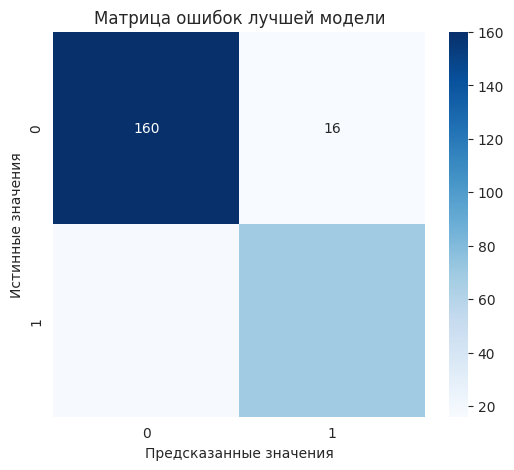

In [9]:
print("6. ЛУЧШАЯ МОДЕЛЬ И ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("=" * 50)

# Находим лучшую модель по F1-score
all_results = pd.DataFrame(results_gd + results_nt)
best_result = all_results.loc[all_results["f1_score"].idxmax()]

print("ЛУЧШАЯ КОНФИГУРАЦИЯ:")
print(f"Метод: {best_result['method']}")
print(f"Learning rate: {best_result['learning_rate']}")
print(f"Количество итераций: {best_result['iterations']}")
print(f"Распределение предсказаний: {best_result['pred_distribution']}")
print()
print("МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ:")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"Precision: {best_result['precision']:.4f}")
print(f"Recall: {best_result['recall']:.4f}")
print(f"F1-Score: {best_result['f1_score']:.4f}")
print()

# Обучение лучшей модели
if best_result["method"] == "Градиентный спуск":
    best_model = LogisticRegression()
    best_model.gradient_descent(
        X_train_scaled,
        y_train.values,
        iterations=int(best_result["iterations"]),
        learning_rate=best_result["learning_rate"],
    )
else:
    best_model = LogisticRegression()
    best_model.newton_optimization(
        X_train_scaled.values, y_train.values, iterations=int(best_result["iterations"])
    )

# Предсказания лучшей модели
y_pred_best = best_model.predict(X_test_scaled)

# Матрица ошибок

cm = confusion_matrix(y_test.values, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок лучшей модели")
plt.ylabel("Истинные значения")
plt.xlabel("Предсказанные значения")
plt.show()